In [1]:
%cd ..

/fs01/home/pwilson/projects/medAI/projects/prostnfound


/h/pwilson/.conda/envs/ai/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import torch 
from medAI.modeling import create_model
from src.loaders import get_dataloaders
from train import ProstNFoundMeta
from argparse import Namespace

checkpoint = '/h/pwilson/projects/medAI/projects/prostnfound/logs/test/prostnfound_plus_final/optimum/checkpoint.pth'
state = torch.load(checkpoint)
args = Namespace(**state['args'])

model = ProstNFoundMeta(create_model(args.model, **args.model_kw))
model.load_state_dict(state['model'])
model.eval()



/h/pwilson/.conda/envs/ai/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/tmp/ipykernel_33880/2683527332.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We reco

Loaded sam state with message _IncompatibleKeys(missing_keys=['mask_decoder._output_upscaling.0.weight', 'mask_decoder._output_upscaling.0.bias', 'mask_decoder._output_upscaling.1.weight', 'mask_decoder._output_upscaling.1.bias', 'mask_decoder._output_upscaling.3.weight', 'mask_decoder._output_upscaling.3.bias'], unexpected_keys=[])


ProstNFoundMeta(
  (model): ProstNFound(
    (medsam_model): Sam(
      (image_encoder): ImageEncoderViT(
        (patch_embed): PatchEmbed(
          (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (blocks): ModuleList(
          (0-11): 12 x Block(
            (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (attn): AdapterAttn(
              (attn): Attention(
                (qkv): Linear(in_features=768, out_features=2304, bias=True)
                (proj): Linear(in_features=768, out_features=768, bias=True)
              )
              (adapter): Adapter(
                (down_project): Linear(in_features=768, out_features=256, bias=True)
                (up_project): Linear(in_features=256, out_features=768, bias=True)
                (act): GELU(approximate='none')
              )
            )
            (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): AdapterMLPBlock(
              (

In [3]:
args.num_workers = 0
args.dataset = 'optimum'

loaders = get_dataloaders(args, mode='test')

In [4]:
from torch.utils.data import default_collate

val_loader = loaders['val']
#batch = next(iter(val_loader))

from copy import deepcopy

val_dataset = val_loader.dataset 
val_dataset_raw = deepcopy(val_dataset)
val_dataset_raw.transform = None 


def get_batch(i):
    item = val_dataset[i]
    batch = default_collate([item])
    raw_item = val_dataset_raw[i]
    return batch, raw_item, item


# def batches(): 
#     for i in range(len(val_dataset)): 
#         item = val_dataset[i]
#         batch = default_collate([item])
#         raw_item = val_dataset_raw[i]
# 
#         yield(batch, raw_item, item)
# 
# 
# batch, raw_item, item = next(batches())



In [5]:
patient2indices = val_dataset.list_indices_by_patient_ids()
patients = sorted(list(patient2indices.keys()))

In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import skimage
from scripts import generate_heatmaps as hm


#fig.tight_layout()

#plt.colorbar()


(256, 256)
(833, 1372)


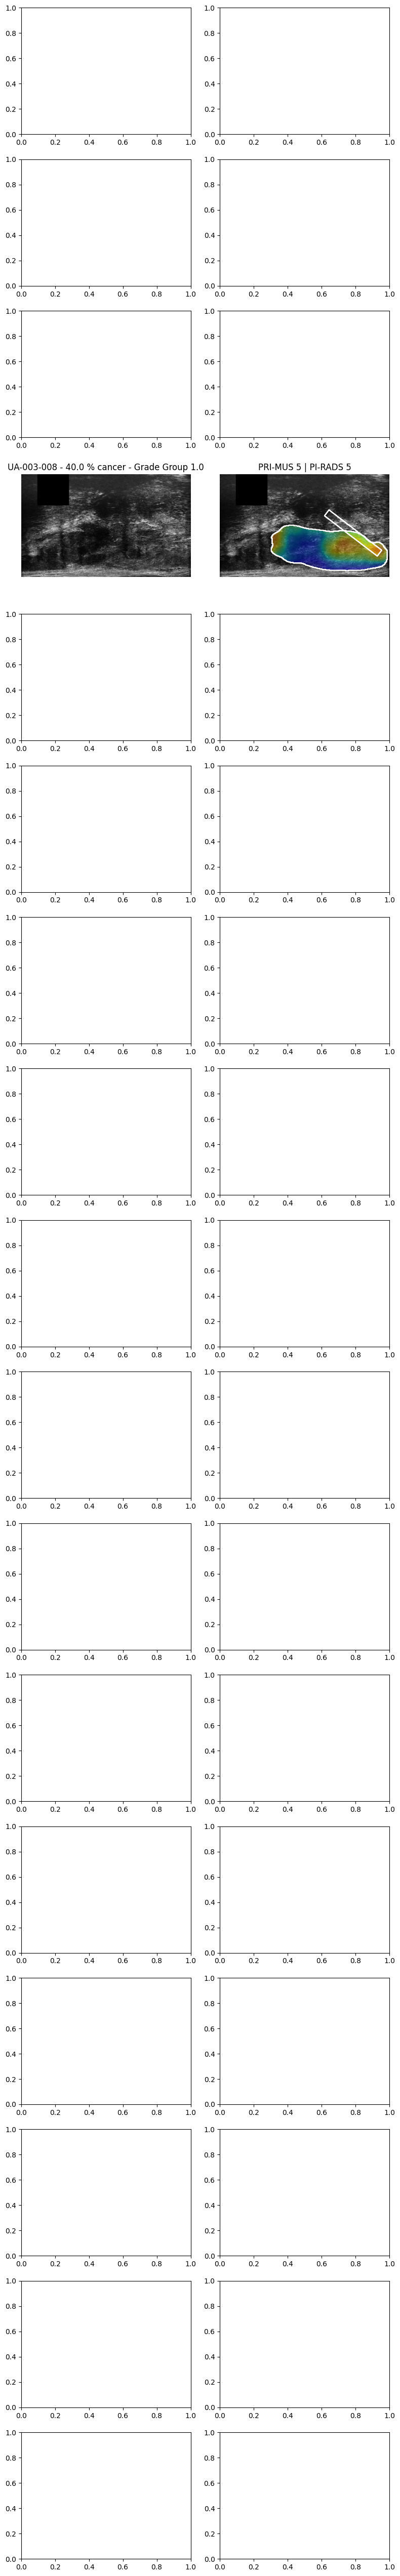

In [36]:
import os
from matplotlib import pyplot as plt

output_dir = 'logs/test/prostnfound_plus_final/optimum/heatmaps_v0'
os.makedirs(output_dir, exist_ok=True)

height = 3
patient = patients[0]
indices = patient2indices[patient]

fig, ax = plt.subplots(len(indices), 2, figsize=(8, height * len(indices)))

for i in range(3, 4):
    batch, raw_item, item = get_batch(indices[i])
    dataset = 'optimum'
    hm.show_heatmap(batch, raw_item, item, model, ax[i], dataset, apply_prostate_mask=True)
    fig.tight_layout()

plt.savefig(os.path.join(output_dir, f"{patient}.png"))


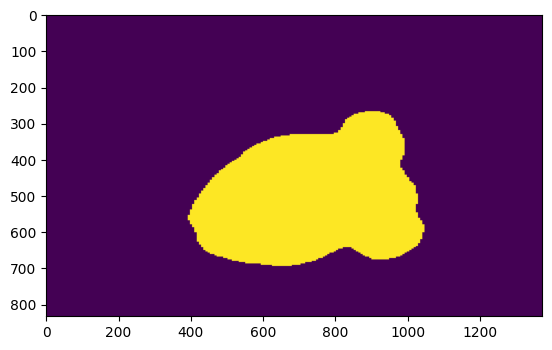

In [18]:
import numpy as np 

plt.imshow(np.array(raw_item['microsegnet_prostate_mask']))

In [19]:
np.array(raw_item['microsegnet_prostate_mask'])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [33]:
raw_item['info']['PI-RADS']

5.0

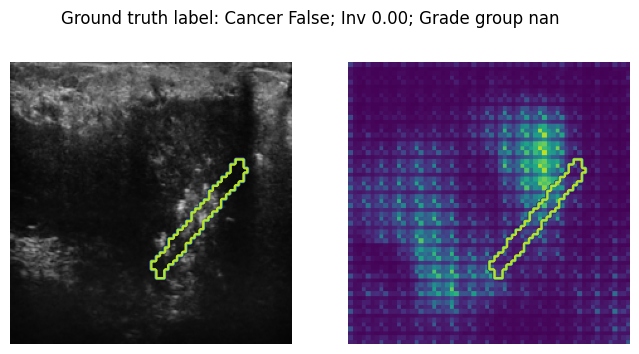

<Figure size 640x480 with 0 Axes>

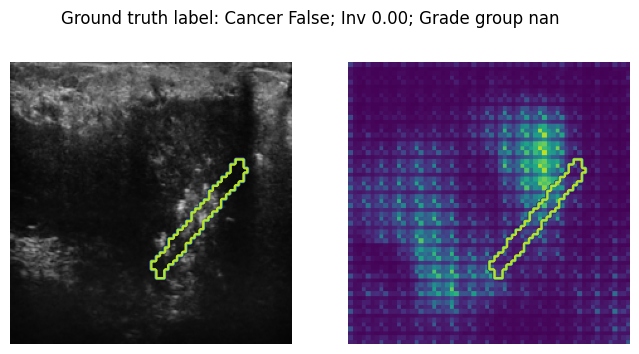

In [54]:
from src.evaluator import show_heatmap_prediction
#out.pop('cancer_logits')
show_heatmap_prediction(out)

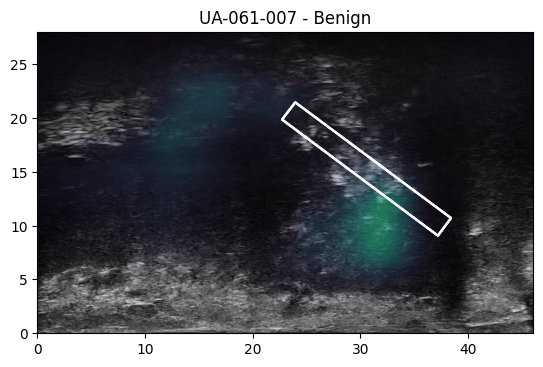

In [22]:
heatmap.shape

(833, 1372, 3)

In [68]:
heatmap.shape

(256, 256)

In [ ]:
sho

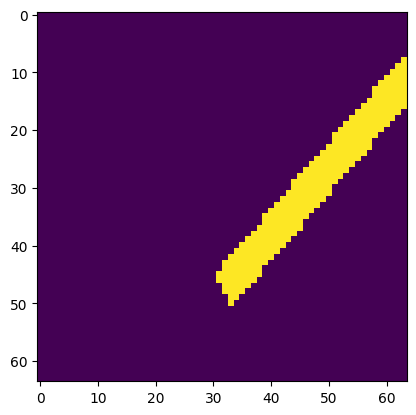

In [34]:
plt.imshow(batch['needle_mask'][0,0])

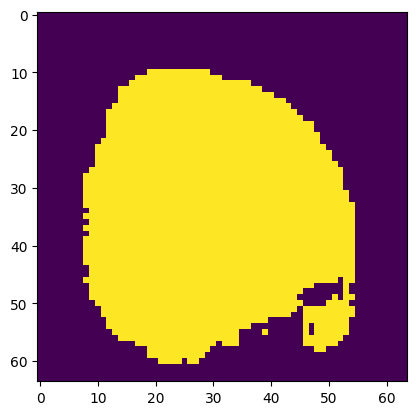

In [8]:
plt.imshow(batch['prostate_mask'][0,0])

In [ ]:
pro

In [41]:
needle_mask.shape

(833, 1372)

In [42]:
prostate_mask.shape

(833, 1372)

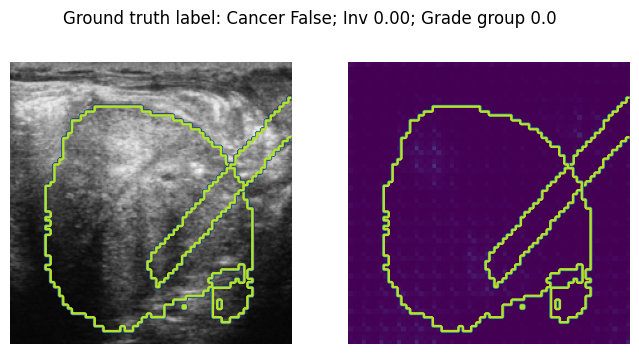

<Figure size 640x480 with 0 Axes>

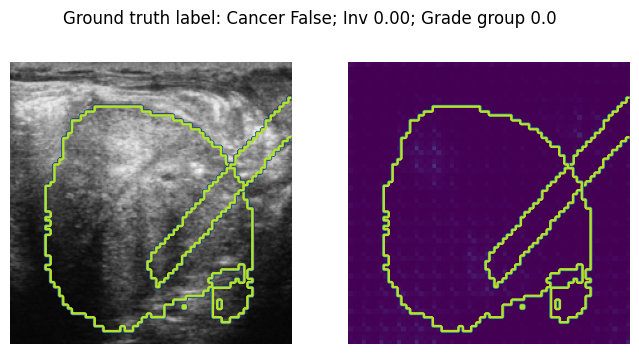

In [9]:
from src.evaluator import show_heatmap_prediction
#out.pop('cancer_logits')
show_heatmap_prediction(out)

In [16]:
out['cancer_probs'].shape

torch.Size([1, 1, 256, 256])

In [13]:
val_loader.dataset[0]['bmode_raw'].shape

(833, 1372)